# Model 5 - UDE Framework

**System:**
$$\frac{dX}{dt} = 1 - d \cdot X$$
$$\frac{dY}{dt} = f_1(X) - f_2(X) \cdot Y - d \cdot Y$$
$$\frac{dZ}{dt} = f_2(X) \cdot Y - d \cdot Z$$

**Unknown:** Functions $f_1(X)$ and $f_2(X)$, and Parameter $d$


In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from ude_framework import (
    create_neural_network,
    create_ude,
    UDETrainer,
    UDEEvaluator
)

%matplotlib inline
np.random.seed(42)
torch.manual_seed(42)

print("✓ UDE Framework loaded!")


✓ UDE Framework loaded!


In [2]:
# ============================================================================
# CONFIGURE EVERYTHING HERE
# ============================================================================

# ----------------------------------------------------------------------------
# 1. DATA FILES
# ----------------------------------------------------------------------------
MEASUREMENTS_FILE = 'model_5_measurements.csv'
INITIAL_CONDITIONS_FILE = 'model_5_initial_conditions.csv'

# State variable names
STATE_NAMES = ['X', 'Y', 'Z']

# Which states are observed in measurements
OBSERVED_STATES = ['X', 'Y', 'Z']  # All states are measured
OBSERVED_INDICES = [STATE_NAMES.index(name) for name in OBSERVED_STATES]

# ----------------------------------------------------------------------------
# 2. UDE STRUCTURE (partial known + NN for unknown)
# ----------------------------------------------------------------------------
def ude_ode_equations(t, y, nn_outputs, known_params):
    """
    UDE for Model 5:
    - KNOWN: constant term and linear terms
    - UNKNOWN: f1(X) and f2(X) learned by NNs
    - LEARNABLE PARAMETER: d
    
    System equations:
    dX/dt = 1 - d*X
    dY/dt = f1(X) - f2(X)*Y - d*Y
    dZ/dt = f2(X)*Y - d*Z
    """
    X = y[..., 0:1]
    Y = y[..., 1:2]
    Z = y[..., 2:3]
    
    # Get NN outputs for f1(X) and f2(X)
    f1_nn = nn_outputs['f1_nn']
    f2_nn = nn_outputs['f2_nn']
    
    if f1_nn.dim() > 2:
        f1_nn = f1_nn.squeeze(-1)
    if f2_nn.dim() > 2:
        f2_nn = f2_nn.squeeze(-1)
    
    # Learnable parameter d
    d = known_params.get('d_learnable', torch.tensor(0.5))
    
    # System structure
    dX_dt = 1.0 - d * X
    dY_dt = f1_nn - f2_nn * Y - d * Y
    dZ_dt = f2_nn * Y - d * Z
    
    return torch.cat([dX_dt, dY_dt, dZ_dt], dim=-1)

# Known parameters for UDE (we'll add learnable d later)
KNOWN_PARAMS = {}

# ----------------------------------------------------------------------------
# 3. NEURAL NETWORK CONFIGURATION  
# ----------------------------------------------------------------------------
NN_INPUT_DIM = 1   # f1 and f2 depend on X
NN_OUTPUT_DIM = 1  # each NN outputs a single value

def nn_input_extractor(y):
    """Extract X (first state) for f1(X) and f2(X)"""
    return y[..., 0:1]  # Returns X

# Architecture for both neural networks
NN_ARCHITECTURE = 'flexible'
NN_CONFIG = {
    'hidden_dims': [32,32,32,32,32,32,32,32,32],
    'activation': 'tanh',
    'final_activation': None,  # f(Y) should be positive
    'use_batch_norm': False,
    'dropout': 0.0
}

# ----------------------------------------------------------------------------
# 4. TRAINING CONFIGURATION
# ----------------------------------------------------------------------------
N_EPOCHS = 1000
LEARNING_RATE = 1e-3
OPTIMIZER = 'adam'
WEIGHT_DECAY = 0.0
GRAD_CLIP = 10

SCHEDULER_TYPE = 'plateau'
SCHEDULER_PARAMS = {
    'factor': 0.5,
    'patience': 80,
    'min_lr': 1e-6,
    'verbose': False
}

ODE_SOLVER = 'dopri8'
ODE_RTOL = 1e-7
ODE_ATOL = 1e-9

LOSS_TYPE = 'mse'
STATE_WEIGHTS = [1.0, 1.0, 1.0]  # Fit all states (all are observed)

PRINT_EVERY = 10

# ----------------------------------------------------------------------------
# 5. VISUALIZATION OF LEARNED FUNCTION
# ----------------------------------------------------------------------------
# We'll visualize the learned f1(X) and f2(X) functions after training
FUNCTION_INPUT_RANGE = np.linspace(0, 5, 300)
FUNCTION_INPUT_NAME = 'X Concentration'

print("✓ Configuration complete!")


✓ Configuration complete!


## 1. Load Data


In [3]:
# Load data from CSV files

# Load measurements
measurements_df = pd.read_csv(MEASUREMENTS_FILE)
t = measurements_df['t'].values
y_measured = measurements_df[OBSERVED_STATES].values  # Only measured states

# Load initial conditions
ic_df = pd.read_csv(INITIAL_CONDITIONS_FILE)
y0 = ic_df[STATE_NAMES].values[0]  # Get first row with all states

# Since we observe all states, use the measurements directly
n_points = len(t)
n_states = len(STATE_NAMES)

# Use measured values for all states
y_noisy = y_measured

# For plotting/comparison, we'll use the same for y_true (since we don't have ground truth)
y_true = y_noisy.copy()

print(f"✓ Loaded {len(t)} measurement points from t={t[0]:.2f} to {t[-1]:.2f}")
print(f"  States: {STATE_NAMES}")
print(f"  Observed states: {OBSERVED_STATES}")
print(f"  Initial conditions: {y0}")


✓ Loaded 30 measurement points from t=0.00 to 10.00
  States: ['X', 'Y', 'Z']
  Observed states: ['X', 'Y', 'Z']
  Initial conditions: [0. 0. 0.]


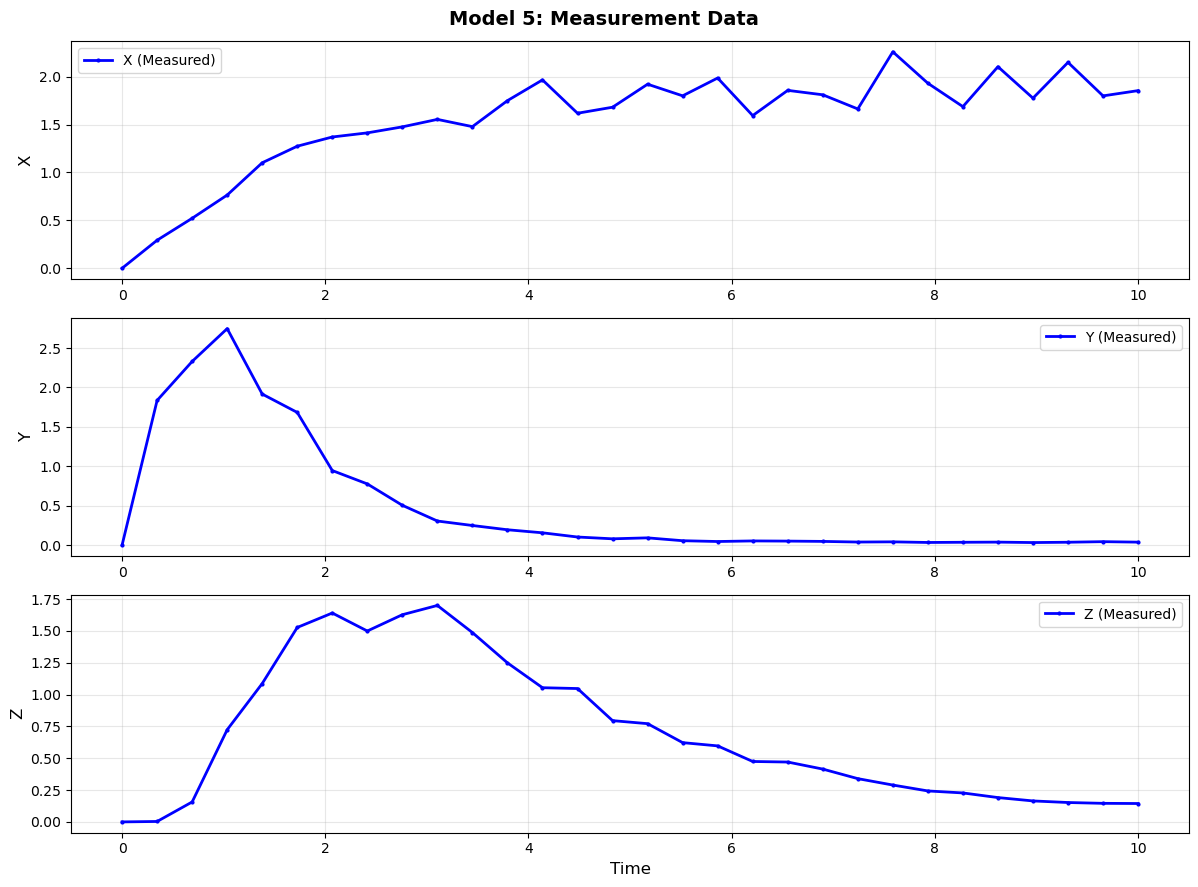

In [4]:
# Visualize data
fig, axes = plt.subplots(3, 1, figsize=(12, 9))

# Plot all states since all are measured
for i, (ax, name) in enumerate(zip(axes, STATE_NAMES)):
    ax.plot(t, y_noisy[:, i], 'b.-', label=f'{name} (Measured)', linewidth=2, markersize=4)
    ax.set_ylabel(name, fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time', fontsize=12)
plt.suptitle('Model 5: Measurement Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 2. Build UDE Model


In [5]:
# Create two neural networks for f1(X) and f2(X)
f1_model = create_neural_network(
    input_dim=NN_INPUT_DIM,
    output_dim=NN_OUTPUT_DIM,
    architecture=NN_ARCHITECTURE,
    **NN_CONFIG
)

f2_model = create_neural_network(
    input_dim=NN_INPUT_DIM,
    output_dim=NN_OUTPUT_DIM,
    architecture=NN_ARCHITECTURE,
    **NN_CONFIG
)

print("Neural Network f1:")
print(f1_model)
print(f"\nf1 Parameters: {f1_model.count_parameters():,}")
print(f"\nNeural Network f2:")
print(f2_model)
print(f"\nf2 Parameters: {f2_model.count_parameters():,}")


Neural Network f1:
FlexibleNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): Tanh()
    (10): Linear(in_features=32, out_features=32, bias=True)
    (11): Tanh()
    (12): Linear(in_features=32, out_features=32, bias=True)
    (13): Tanh()
    (14): Linear(in_features=32, out_features=32, bias=True)
    (15): Tanh()
    (16): Linear(in_features=32, out_features=32, bias=True)
    (17): Tanh()
    (18): Linear(in_features=32, out_features=1, bias=True)
  )
)

f1 Parameters: 8,545

Neural Network f2:
FlexibleNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_featu

In [6]:
# Wrap NNs to extract correct input from state vector
class NNWrapper(nn.Module):
    def __init__(self, nn, input_extractor):
        super().__init__()
        self.nn = nn
        self.input_extractor = input_extractor
    
    def forward(self, t, y):
        nn_input = self.input_extractor(y)
        return self.nn(t, nn_input)

# Wrap both neural networks
f1_wrapped = NNWrapper(f1_model, nn_input_extractor)
f2_wrapped = NNWrapper(f2_model, nn_input_extractor)

# Add learnable parameter d
d_learnable = nn.Parameter(torch.tensor(0.5))  # Initial guess
KNOWN_PARAMS['d_learnable'] = d_learnable

# Create UDE with both neural networks
ude_model = create_ude(
    n_states=len(STATE_NAMES),
    ode_func=ude_ode_equations,
    neural_networks={'f1_nn': f1_wrapped, 'f2_nn': f2_wrapped},
    known_params=KNOWN_PARAMS
)

# Register parameter
ude_model.register_parameter('d_learnable', d_learnable)

print(f"\n✓ UDE Model created!")
f1_params = f1_model.count_parameters()
f2_params = f2_model.count_parameters()
print(f"  f1 NN parameters: {f1_params}")
print(f"  f2 NN parameters: {f2_params}")
print(f"  Total NN parameters: {f1_params + f2_params}")
print(f"  Initial d: {d_learnable.item():.4f}")



✓ UDE Model created!
  f1 NN parameters: 8545
  f2 NN parameters: 8545
  Total NN parameters: 17090
  Initial d: 0.5000


## 3. Train UDE


In [7]:
# Convert to tensors
t_torch = torch.tensor(t, dtype=torch.float32)
y_noisy_torch = torch.tensor(y_noisy, dtype=torch.float32)
y_true_torch = torch.tensor(y_true, dtype=torch.float32)
y0_torch = torch.tensor(y0, dtype=torch.float32)

# Create trainer
trainer = UDETrainer(
    ude_model=ude_model,
    optimizer_name=OPTIMIZER,
    learning_rate=LEARNING_RATE,
    scheduler_type=SCHEDULER_TYPE,
    scheduler_params=SCHEDULER_PARAMS,
    weight_decay=WEIGHT_DECAY,
    grad_clip=GRAD_CLIP,
    ode_solver=ODE_SOLVER,
    ode_rtol=ODE_RTOL,
    ode_atol=ODE_ATOL
)

print("✓ Trainer initialized")


✓ Trainer initialized


/opt/miniconda3/envs/himanshu-quant-research/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Train!
print(f"\n{'='*60}")
print(f"TRAINING ({N_EPOCHS} epochs)")
print(f"{'='*60}\n")

# Convert weights to tensor if provided
weights_torch = torch.tensor(STATE_WEIGHTS, dtype=torch.float32) if STATE_WEIGHTS is not None else None

trainer.train(
    y0=y0_torch,
    t=t_torch,
    y_true=y_noisy_torch,
    n_epochs=N_EPOCHS,
    weights=weights_torch,
    loss_type=LOSS_TYPE,
    print_every=PRINT_EVERY
)

print(f"\n✓ Training complete!")
print(f"  Learned d: {ude_model.d_learnable.item():.4f}")



TRAINING (1000 epochs)

Starting training for 1000 epochs...
Optimizer: Adam
Learning rate: 0.001
ODE solver: dopri8

Epoch 1/1000 | Loss: 1.520096 | LR: 0.001000 | Grad: 0.9570
Epoch 10/1000 | Loss: 1.247699 | LR: 0.001000 | Grad: 0.8293
Epoch 20/1000 | Loss: 1.067651 | LR: 0.001000 | Grad: 0.5996
Epoch 30/1000 | Loss: 0.947298 | LR: 0.001000 | Grad: 0.8006
Epoch 40/1000 | Loss: 0.418990 | LR: 0.001000 | Grad: 1.4500
Epoch 50/1000 | Loss: 0.329545 | LR: 0.001000 | Grad: 2.6121
Epoch 60/1000 | Loss: 0.263157 | LR: 0.001000 | Grad: 1.0101
Epoch 70/1000 | Loss: 0.163379 | LR: 0.001000 | Grad: 0.9678
Epoch 80/1000 | Loss: 0.103508 | LR: 0.001000 | Grad: 0.3620
Epoch 90/1000 | Loss: 0.093320 | LR: 0.001000 | Grad: 0.3804
Epoch 100/1000 | Loss: 0.075778 | LR: 0.001000 | Grad: 0.1866
Epoch 110/1000 | Loss: 0.065547 | LR: 0.001000 | Grad: 0.1997
Epoch 120/1000 | Loss: 0.056701 | LR: 0.001000 | Grad: 0.7153
Epoch 130/1000 | Loss: 0.054582 | LR: 0.001000 | Grad: 1.7991
Epoch 140/1000 | Loss: 0

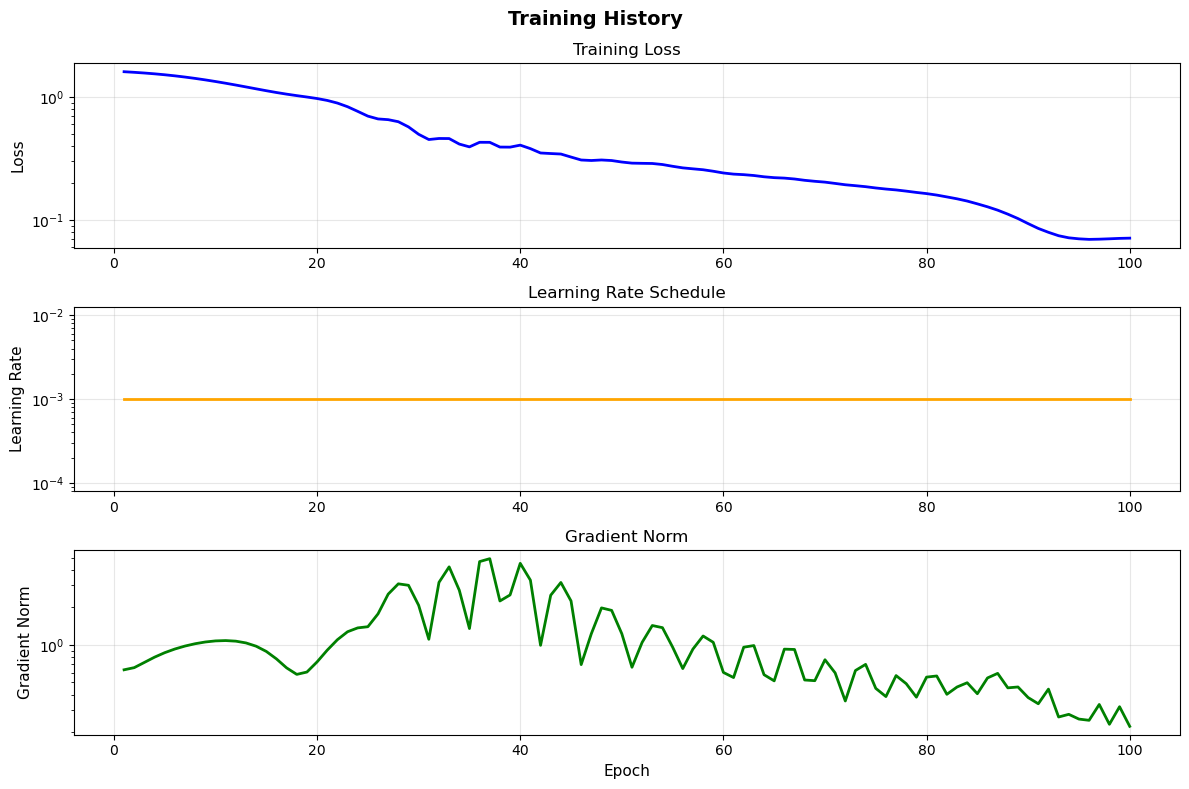

In [ ]:
# Plot training history
history = trainer.get_history()
evaluator = UDEEvaluator(ude_model, STATE_NAMES)
evaluator.plot_training_history(history)


## 4. Evaluate UDE Performance


In [ ]:
# Get predictions
with torch.no_grad():
    y_pred = trainer.forward_solve(y0_torch, t_torch).numpy()

# Compute metrics for all states
mse_total = np.mean((y_pred - y_true)**2)
rmse_total = np.sqrt(mse_total)
mae_total = np.mean(np.abs(y_pred - y_true))

print(f"\n{'='*60}")
print("PREDICTION METRICS (All States)")
print(f"{'='*60}")
print(f"  Total MSE:  {mse_total:.6f}")
print(f"  Total RMSE: {rmse_total:.6f}")
print(f"  Total MAE:  {mae_total:.6f}")
print(f"\nPer-State Metrics:")
for i, name in enumerate(STATE_NAMES):
    mse = np.mean((y_pred[:, i] - y_true[:, i])**2)
    print(f"  {name}: MSE = {mse:.6f}")
print(f"{'='*60}")



PREDICTION METRICS (All States)
  Total MSE:  0.023790
  Total RMSE: 0.154239
  Total MAE:  0.094164

Per-State Metrics:
  X: MSE = 0.021204
  Y: MSE = 0.024417
  Z: MSE = 0.025748


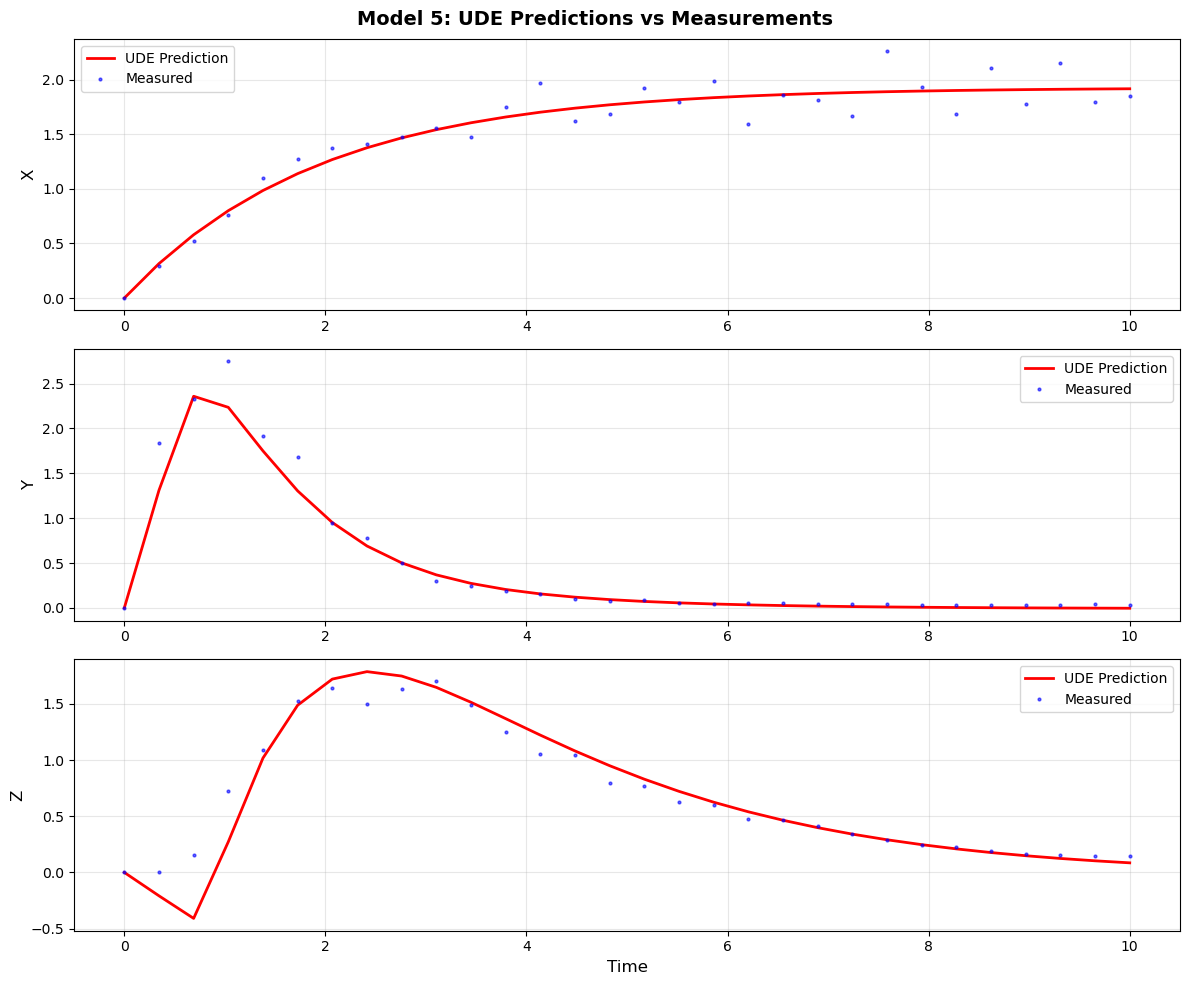

In [ ]:
# Plot trajectories (all 3 states)
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

for i, (ax, name) in enumerate(zip(axes, STATE_NAMES)):
    ax.plot(t, y_pred[:, i], 'r-', label='UDE Prediction', linewidth=2)
    ax.plot(t, y_true[:, i], 'b.', label='Measured', alpha=0.6, markersize=4)
    
    ax.set_ylabel(name, fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time', fontsize=12)
plt.suptitle('Model 5: UDE Predictions vs Measurements', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 5. Visualize Learned Function f(P)


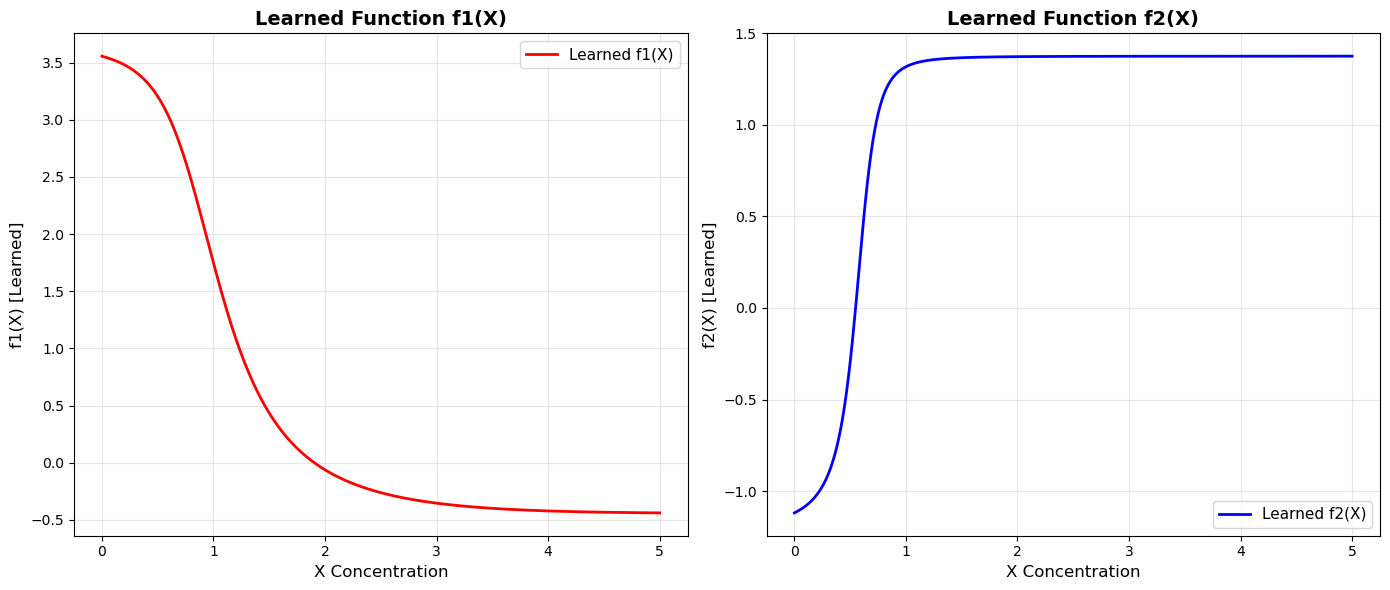

In [ ]:
# Visualize the learned f1(X) and f2(X) functions
X_range = torch.tensor(FUNCTION_INPUT_RANGE.reshape(-1, 1), dtype=torch.float32)
t_dummy = torch.zeros_like(X_range[:, 0])

with torch.no_grad():
    f1_learned = f1_model(t_dummy, X_range).numpy()
    f2_learned = f2_model(t_dummy, X_range).numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot f1(X)
ax1.plot(FUNCTION_INPUT_RANGE, f1_learned, 'r-', linewidth=2, label='Learned f1(X)')
ax1.set_xlabel(FUNCTION_INPUT_NAME, fontsize=12)
ax1.set_ylabel('f1(X) [Learned]', fontsize=12)
ax1.set_title('Learned Function f1(X)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot f2(X)
ax2.plot(FUNCTION_INPUT_RANGE, f2_learned, 'b-', linewidth=2, label='Learned f2(X)')
ax2.set_xlabel(FUNCTION_INPUT_NAME, fontsize=12)
ax2.set_ylabel('f2(X) [Learned]', fontsize=12)
ax2.set_title('Learned Function f2(X)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Parameter Summary


In [ ]:
# Display learned parameters
print("\n" + "="*60)
print("LEARNED PARAMETERS")
print("="*60)
print(f"\nParameter d (decay rate):")
print(f"  Learned value: {ude_model.d_learnable.item():.4f}")
print("\nNeural Network f1(X):")
f1_params = f1_model.count_parameters()
print(f"  Total parameters: {f1_params}")
print("\nNeural Network f2(X):")
f2_params = f2_model.count_parameters()
print(f"  Total parameters: {f2_params}")
print(f"\nCombined NN parameters: {f1_params + f2_params}")



LEARNED PARAMETERS

Parameter d (decay rate):
  Learned value: 0.5189

Neural Network f1(X):
  Total parameters: 8545

Neural Network f2(X):
  Total parameters: 8545

Combined NN parameters: 17090
